Convenience functions for automatic reloading .py files

In [24]:
%load_ext autoreload
%autoreload 2

Check whether video procesing in opencv is working (I had some trouble with it and had to build from source)

In [1]:
import os
VIDEO_PATH = os.path.abspath('test.mp4')
COCO_WEIGHTS_PATH = os.path.abspath('mask_rcnn_coco.h5')
LOGS_DIR = os.path.abspath('logs')


In [2]:
import cv2
print(cv2.__version__)
video = cv2.VideoCapture(VIDEO_PATH)
print(video.isOpened())

3.4.4
True


In [3]:
from coco import coco
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

Using TensorFlow backend.


In [4]:
import mrcnn
# Create model object in inference mode.
model = mrcnn.model.MaskRCNN(mode="inference", model_dir=LOGS_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [5]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [6]:
import numpy as np
def rotate_bound(image, angle):
    #Source: https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

Get and process the frame from the video

In [7]:
success, frame_bgr = video.read()

#convert from opencv bgr to rgb
frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

#rotate (I don't know why the image isn't read properly to begin with)
frame = rotate_bound(frame_rgb, -90)

In [23]:
# Run detection
results = model.detect([frame], verbose=1)

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Visualization using matplotlib

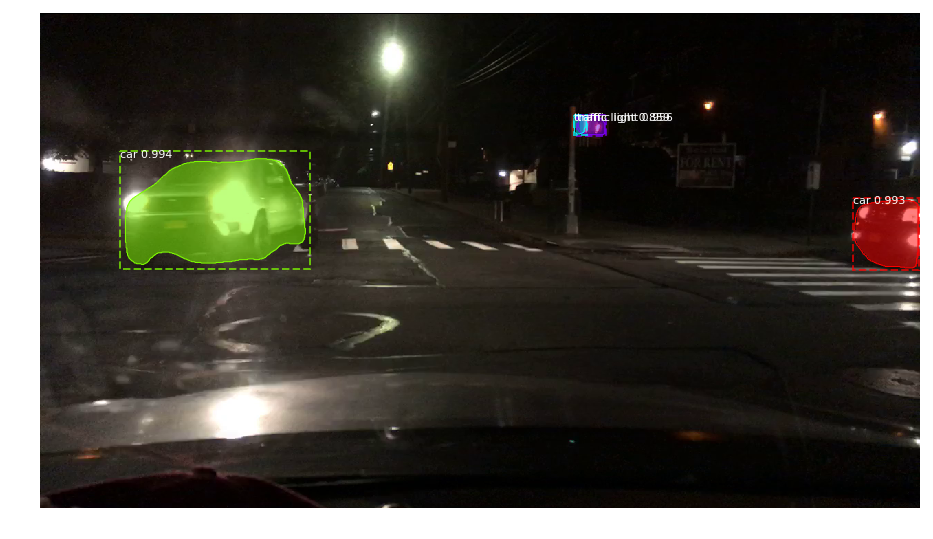

In [25]:
from mrcnn import visualize

# Visualize results
r = results[0]
visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Visualize as an image (easier to export to a video file later).

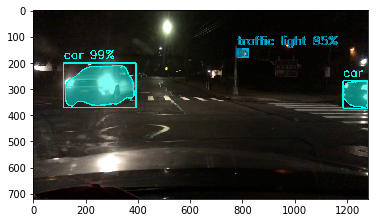

In [28]:
from mrcnn import visualize2
import matplotlib.pyplot as plt
a = visualize2.get_instances_image(frame, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

plt.imshow(a)